# Fine Tuning a pre-trained Deep CNN on a GPU machine

This session is inspired by [a blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) by François Chollet, the creator of the Keras library.

**WARNING**: the execution of notebook **requires a GPU** e.g. nvidia K80, GTX 980 or later with **at least 6GB of GPU RAM**.


For this session we are going to use the dataset of the [dogs-vs-cats](https://www.kaggle.com/c/dogs-vs-cats/data).

To download the data yourself, create a password-based account on Kaggle, then click on the download link of one of the data file **when you are logged-in in your browser** to get to the form that makes you accept the terms and conditions of that challenge.

Then in a shell session possibly on a server do the following:

```bash
pip install kaggle-cli
mkdir -p ~/data/dogs-vs-cats
cd ~/data/dogs-vs-cats
kg download -u username -p password -c dogs-vs-cats
```

This should download 3 files among which: `train.zip` and `test1.zip` (and a CSV template file we won't need).

Once this is done **we can extract the archives for the train set**:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import os
import os.path as op
import shutil
from zipfile import ZipFile

data_folder = op.expanduser('~/data/dogs-vs-cats')
train_folder = op.join(data_folder, 'train')

if not op.exists(train_folder):
    train_zip = op.join(data_folder, 'train.zip')
    print('Extracting %s...' % train_zip)
    ZipFile(train_zip).extractall(data_folder)

The Keras image data helpers want images for different classes ('cat' and 'dog') to live in distinct subfolders. Let's rearrange the image files to follow that convention:

In [2]:
def rearrange_folders(folder):
    image_filenames = [op.join(folder, fn) for fn in os.listdir(folder)
                       if fn.endswith('.jpg')]
    if len(image_filenames) == 0:
        return
    print("Rearranging %d images in %s into one subfolder per class..."
          % (len(image_filenames), folder))
    for image_filename in image_filenames:
        subfolder, _ = image_filename.split('.', 1)
        subfolder = op.join(folder, subfolder)
        if not op.exists(subfolder):
            os.mkdir(subfolder)
        shutil.move(image_filename, subfolder)


rearrange_folders(train_folder)

Lets build a validation dataset by taking 500 images of cats and 500 images of dogs out of the training set:

In [3]:
n_validation = 500

validation_folder = op.join(data_folder, 'validation')
if not op.exists(validation_folder):
    os.mkdir(validation_folder)
    for class_name in ['dog', 'cat']:
        train_subfolder = op.join(train_folder, class_name)
        validation_subfolder = op.join(validation_folder, class_name)
        print("Populating %s..." % validation_subfolder)
        os.mkdir(validation_subfolder)
        images_filenames = sorted(os.listdir(train_subfolder))
        for image_filename in images_filenames[-n_validation:]:
            shutil.move(op.join(train_subfolder, image_filename),
                        validation_subfolder)
        print("Moved %d images" % len(os.listdir(validation_subfolder)))

## Data Loading and Data Augmentation


Let's use keras utilities to manually load the first image file of the cat folder. If keras complains about the missing "PIL" library, make sure to install it with one of the following commands:

```bash
conda install pillow

# or

pip install pillow
```

You might need to restart the kernel of this notebook to get Keras work.

In [4]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

img = load_img(op.join(train_folder, 'cat', 'cat.249.jpg'))
x = img_to_array(img)

print(x.shape)

Using TensorFlow backend.


(336, 344, 3)


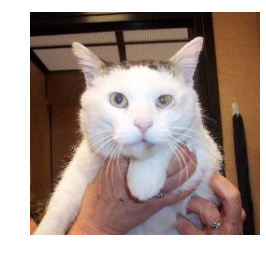

In [5]:
plt.imshow(x.astype(np.uint8))
plt.axis('off');

Keras provides tools to generate many variations from a single image: this is useful to augment the dataset with variants that should not affect the image label: a rotated image of a cat is an image of a cat.

Doing data augmentation at train time make neural networks ignore such label-preserving transformations and therefore help reduce overfitting.

In [6]:
from keras.preprocessing.image import ImageDataGenerator


augmenting_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=9,
    fill_mode='nearest'
)

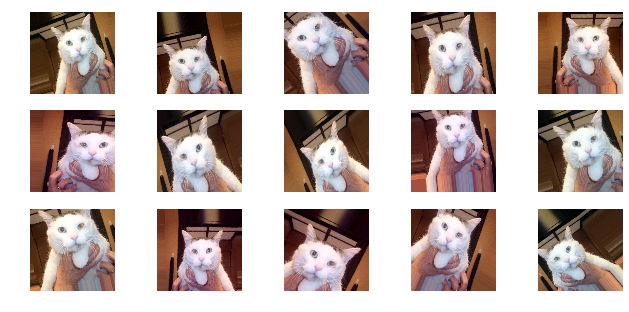

In [7]:
plt.figure(figsize=(11, 5))
flow = augmenting_datagen.flow(x[np.newaxis, :, :, :])
for i, x_augmented in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_augmented[0])
    plt.axis('off')

The `ImageDataGenerator` object can the be pointed to the dataset folder both load the image and augment them on the fly and resize / crop them to fit the input dimensions of the classification neural network.

Found 24000 images belonging to 2 classes.


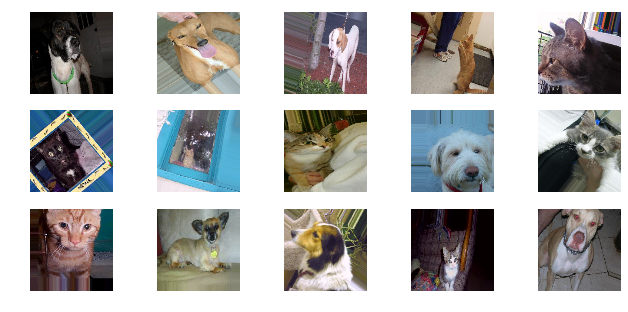

In [8]:
flow = augmenting_datagen.flow_from_directory(
    train_folder, batch_size=1, target_size=(224, 224))

plt.figure(figsize=(11, 5))
for i, (X, y) in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X[0])
    plt.axis('off')

## Loading a pre-trained computer vision model

Let us load a state of the art model with a good tradeoff between prediction speed, model size and predictive accuracy, namely a Residual Network with 54 parameterized layers (53 convolutional + 1 fully connected for the softmax):

In [9]:
from keras.applications.resnet50 import ResNet50, preprocess_input

full_imagenet_model = ResNet50(weights='imagenet')

In [10]:
# print(full_imagenet_model.summary())

If you have `graphviz` system package and the `pydot_ng` python package installed you can uncomment the following cell to display the structure of the network.

In [11]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# model_viz = model_to_dot(full_imagenet_model,
#                          show_layer_names=False,
#                          show_shapes=True)
# SVG(model_viz.create(prog='dot', format='svg'))

## Transfer learning

Let's remove the last dense classification layer that is specific to the image net classes and use the previous layer (after flattening) as a feature extractor:

In [12]:
from keras.models import Model

output = full_imagenet_model.layers[-2].output
base_model = Model(full_imagenet_model.input, output)

When using this model we need to be careful to apply the same image processing as was used during the training, otherwise the marginal distribution of the input pixels might not be on the right scale:

In [13]:
def preprocess_function(x):
    if x.ndim == 3:
        x = x[np.newaxis, :, :, :]
    return preprocess_input(x)

In [14]:
batch_size = 50

datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

train_flow = datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

X, y = next(train_flow)
print(X.shape, y.shape)

Found 24000 images belonging to 2 classes.
(50, 224, 224, 3) (50,)


**Exercise**: write a function that iterate of over 5000 images in the training set (bach after batch), extracts the activations of the last layer of `base_model` (by calling predicts) and collect the results in a big numpy array with dimensions `(5000, 2048)` for the features and `(5000,)` for the matching image labels.

In [15]:
# %load solutions/dogs_vs_cats_extract_features.py
from time import time

features = []
labels = []

t0 = time()
count = 0
for X, y in train_flow:
    labels.append(y)
    features.append(base_model.predict(X))
    count += len(y)
    if count % 100 == 0:
        print("processed %d images at %d images/s"
              % (count, count / (time() - t0)))
    if count >= 5000:
        break

labels_train = np.concatenate(labels)
features_train = np.vstack(features)
np.save('labels_train.npy', labels_train)
np.save('features_train.npy', features_train)

Let's load precomputed features if available:

In [16]:
print("Loading precomputed features")
labels_train = np.load('labels_train.npy')
features_train = np.load('features_train.npy')

Loading precomputed features


Let's train a simple linear model on those features. First let's check that the resulting small dataset has balanced classes:

In [17]:
print(labels_train.shape)

(5000,)


In [18]:
np.mean(labels_train)

0.4998

In [19]:
n_samples, n_features = features_train.shape
print(n_features, "features extracted")

2048 features extracted


Let's define the classification model:

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam


top_model = Sequential()
top_model.add(Dense(1, input_dim=n_features, activation='sigmoid'))
top_model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

top_model.fit(features_train, labels_train,
              validation_split=0.1, verbose=2, epochs=15)

Train on 4500 samples, validate on 500 samples
Epoch 1/15
 - 1s - loss: 0.3513 - acc: 0.8756 - val_loss: 0.2146 - val_acc: 0.9520
Epoch 2/15
 - 0s - loss: 0.1600 - acc: 0.9642 - val_loss: 0.1296 - val_acc: 0.9760
Epoch 3/15
 - 0s - loss: 0.1091 - acc: 0.9738 - val_loss: 0.0966 - val_acc: 0.9860
Epoch 4/15
 - 1s - loss: 0.0851 - acc: 0.9789 - val_loss: 0.0795 - val_acc: 0.9860
Epoch 5/15
 - 1s - loss: 0.0709 - acc: 0.9813 - val_loss: 0.0690 - val_acc: 0.9860
Epoch 6/15
 - 1s - loss: 0.0616 - acc: 0.9829 - val_loss: 0.0620 - val_acc: 0.9860
Epoch 7/15
 - 0s - loss: 0.0548 - acc: 0.9856 - val_loss: 0.0588 - val_acc: 0.9900
Epoch 8/15
 - 0s - loss: 0.0497 - acc: 0.9858 - val_loss: 0.0539 - val_acc: 0.9860
Epoch 9/15
 - 0s - loss: 0.0455 - acc: 0.9873 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 10/15
 - 0s - loss: 0.0419 - acc: 0.9884 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 11/15
 - 0s - loss: 0.0390 - acc: 0.9896 - val_loss: 0.0482 - val_acc: 0.9860
Epoch 12/15
 - 0s - loss: 0.0363 - acc

Alright so the transfer learning is already at ~0.98 / 0.99 accuracy. This is not too surprising as the cats and dogs classes are already part of the imagenet label set.

Note that this is **already as good or slightly better than the winner of the original kaggle competition** [three years ago](https://www.kaggle.com/c/dogs-vs-cats/leaderboard). At that time they did not have pretrained resnet models at hand.

Or validation set has 1000 images, so an accuracy of 0.990 means only 10 classification errors.

Let's plug this on top the base model to be able to use it to make some classifications on our held out validation image folder:

In [22]:
model = Model(base_model.input, top_model(base_model.output))

Found 1000 images belonging to 2 classes.


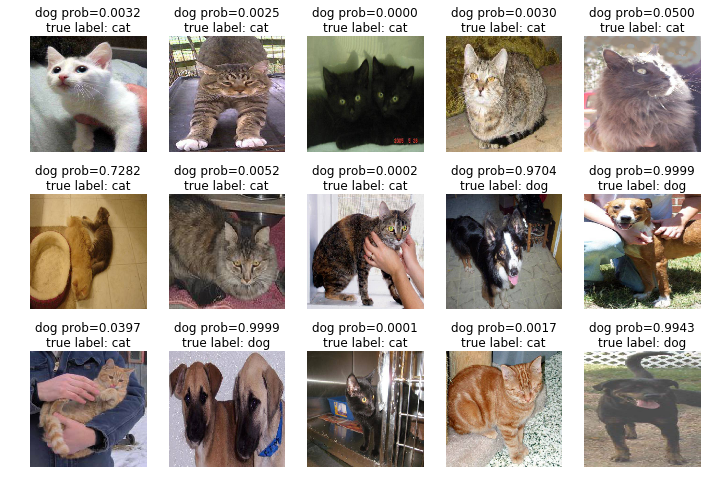

In [23]:
flow = ImageDataGenerator().flow_from_directory(
        validation_folder, batch_size=1, target_size=(224, 224))

plt.figure(figsize=(12, 8))
for i, (X, y) in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X[0] / 255)
    prediction = model.predict(preprocess_input(X))
    label = "dog" if y[:, 1] > 0.5 else "cat"
    plt.title("dog prob=%0.4f\ntrue label: %s"
              % (prediction, label))
    plt.axis('off')

Let's compute the validation score on the full validation set:

In [25]:
valgen = ImageDataGenerator(preprocessing_function=preprocess_function)
val_flow = valgen.flow_from_directory(
    validation_folder, batch_size=batch_size, target_size=(224, 224),
    shuffle=False, class_mode='binary')

all_correct = []
for i, (X, y) in zip(range(val_flow.n // batch_size), val_flow):
    predictions = model.predict(X).ravel()
    correct = list((predictions > 0.5) == y)
    all_correct.extend(correct)
    print("Processed %d images" % len(all_correct))
    
print("Validation accuracy: %0.4f" % np.mean(all_correct))

Found 1000 images belonging to 2 classes.
Processed 50 images
Processed 100 images
Processed 150 images
Processed 200 images
Processed 250 images
Processed 300 images
Processed 350 images
Processed 400 images
Processed 450 images
Processed 500 images
Processed 550 images
Processed 600 images
Processed 650 images
Processed 700 images
Processed 750 images
Processed 800 images
Processed 850 images
Processed 900 images
Processed 950 images
Processed 1000 images
Validation accuracy: 0.9880


**Exercise:** display the example where the model makes the most confident mistakes.

To display images in jupyter notebook you can use:

```python
from IPython.display import Image, display
import os.path as op

display(Image(op.join(validation_folder, image_name)))
```

The filenames of items sampled by a flow (without random shuffling) can be accessed via: `val_flow.filenames`.

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20
predicted dog probability: 0.9325


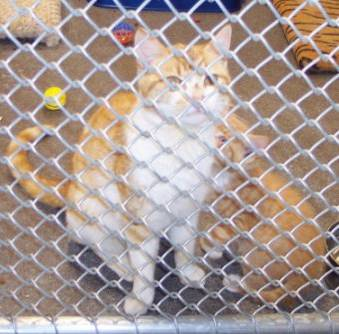

predicted dog probability: 0.8453


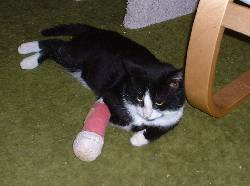

predicted dog probability: 0.8132


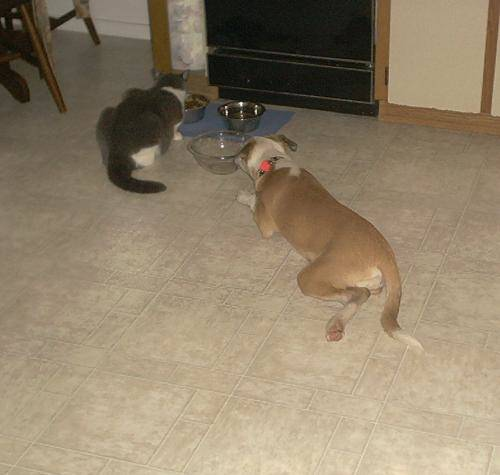

predicted dog probability: 0.7485


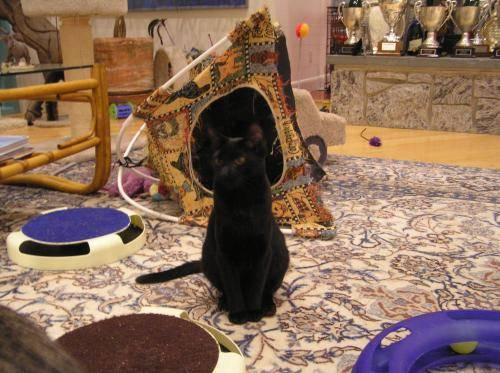

predicted dog probability: 0.2603


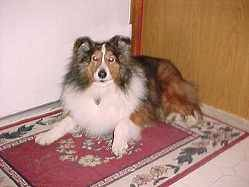

predicted dog probability: 0.7282


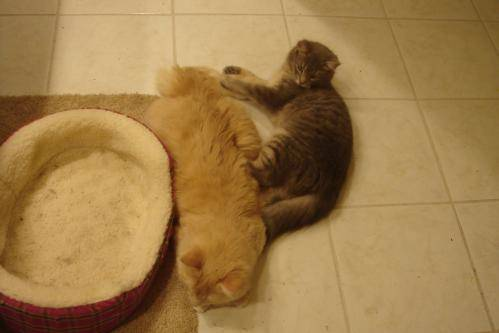

predicted dog probability: 0.3080


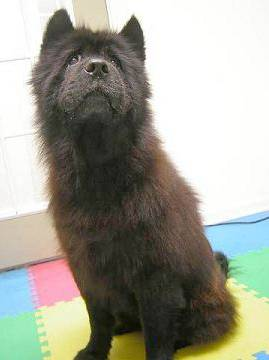

predicted dog probability: 0.6787


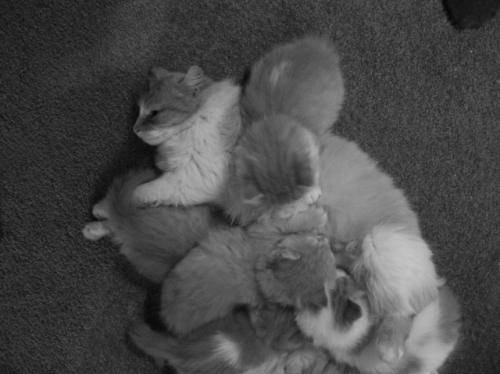

predicted dog probability: 0.3224


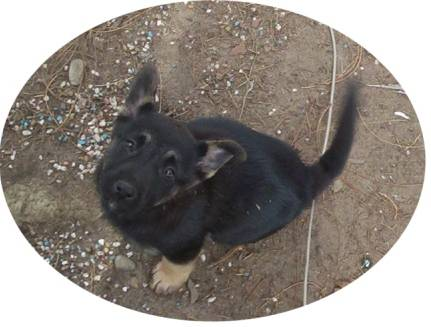

predicted dog probability: 0.6428


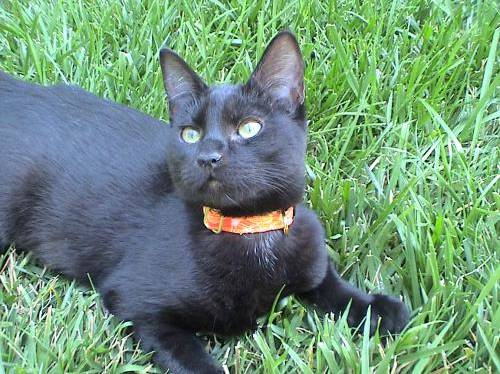

In [28]:
# %load solutions/dogs_vs_cats_worst_predictions.py
from IPython.display import Image, display

predicted_batches = []
label_batches = []
n_batches = val_flow.n // batch_size
for i, (X, y) in zip(range(n_batches), val_flow):
    predicted_batches.append(model.predict(X).ravel())
    label_batches.append(y)
    print("%d/%d" % (i + 1, n_batches))

predictions = np.concatenate(predicted_batches)
true_labels = np.concatenate(label_batches)
top_offenders = np.abs(predictions - true_labels).argsort()[::-1][:10]

image_names = np.array(val_flow.filenames, dtype=np.object)[top_offenders]
for img, pred in zip(image_names, predictions[top_offenders]):
    print("predicted dog probability: %0.4f" % pred)
    display(Image(op.join(validation_folder, img)))

# Analysis:
#
# The  worst offender has the grid occlusion: this kind of grids is
# probably much more frequent for dogs in in the rest of the training
# set. This is an unwanted bias of our dataset.
#
# To fix it we would probably need to add other images with similar
# occlusion patterns to teach the model to be invariant to them.
# This could be achieved with a dedicated data augmentation scheme.
#
# The image with both a dog and a cat could clearly be considered a
# labeling error: this kind of ambiguous images should be removed
# from the validation set to properly asses the generalization ability
# of the model.
#
# The other errors are harder to understand. Introspecting the gradients
# back to the pixel space could help understand what's misleading the
# model. It could be some elements in the background that are
# statistically very correlated to dogs in the training set.

## Fine tuning

Let's identify the location of the residual blocks (merge by addition in a residual architecture):

In [30]:
from keras.layers import Add

[(i, l.output_shape)
 for (i, l) in enumerate(model.layers)
 if isinstance(l, Add)]

[(15, (None, 55, 55, 256)),
 (25, (None, 55, 55, 256)),
 (35, (None, 55, 55, 256)),
 (47, (None, 28, 28, 512)),
 (57, (None, 28, 28, 512)),
 (67, (None, 28, 28, 512)),
 (77, (None, 28, 28, 512)),
 (89, (None, 14, 14, 1024)),
 (99, (None, 14, 14, 1024)),
 (109, (None, 14, 14, 1024)),
 (119, (None, 14, 14, 1024)),
 (129, (None, 14, 14, 1024)),
 (139, (None, 14, 14, 1024)),
 (151, (None, 7, 7, 2048)),
 (161, (None, 7, 7, 2048)),
 (171, (None, 7, 7, 2048))]

Let's fix the weights of the low level layers and fine tune the top level layers:

In [31]:
for i, layer in enumerate(model.layers):
    layer.trainable = i >= 151

Let's fine tune a bit the top level layers to see if we can further improve the accuracy. Use the **nvidia-smi** command in a bash terminal on the server to monitor the GPU usage when the model is training.

In [ ]:
from keras import optimizers

augmenting_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_function,
)
train_flow = augmenting_datagen.flow_from_directory(
    train_folder, target_size=(224, 224), batch_size=batch_size,
    class_mode='binary', shuffle=True, seed=0)

opt = optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy',
              metrics=['accuracy'])


# compute the validation metrics every 5000 training samples
history = model.fit_generator(train_flow, 5000,
                              epochs=30,
                              validation_data=val_flow,
                              validation_steps=val_flow.n)

# Note: the pretrained model was already very good. Fine tuning
# does not really seem to help. It might be more interesting to
# introspect the quality of the labeling in the training set to
# check for images that are too ambiguous and should be removed
# from the training set.

**Bonus exercise**: train your own architecture from scratch using adam and data augmentation. Start with a small architecture first (e.g. 4 convolutions layers interleaved with 2 max pooling layers followed by a `Flatten` and two fully connected layers).

**Bonus exercise**: run this notebook on an instance with several GPUs (NC12 or NC24 instances on Azure) and try to speed up the training with: https://medium.com/@kuza55/transparent-multi-gpu-training-on-tensorflow-with-keras-8b0016fd9012